In [1]:
import scanpy as sc
import os
import bin2cell as b2c
import celltypist
from celltypist import models
import numpy as np
from matplotlib import rcParams
from matplotlib import font_manager
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation
from PIL import Image

In [2]:
file_path = "./skin_TXK6Z4X_A1/binned_outputs/square_008um"
source_image_path = "../Example_Data/H1-TXK6Z4X-A1_2um/H1-TXK6Z4X-A1_SK24-001_A1-4-003.tiff"
os.makedirs("stardist", exist_ok=True)
bdata = b2c.read_visium(file_path, source_image_path = source_image_path)
bdata.var_names_make_unique()
bdata

AnnData object with n_obs × n_vars = 310118 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
bdata.raw = bdata

In [4]:
sc.pp.filter_genes(bdata, min_cells=3)
sc.pp.filter_cells(bdata, min_genes=100)
bdata.var["mt"] = bdata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(bdata, qc_vars=["mt"], percent_top=[20], inplace=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


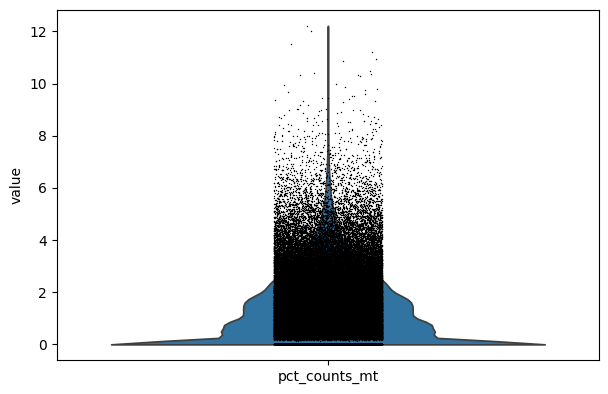

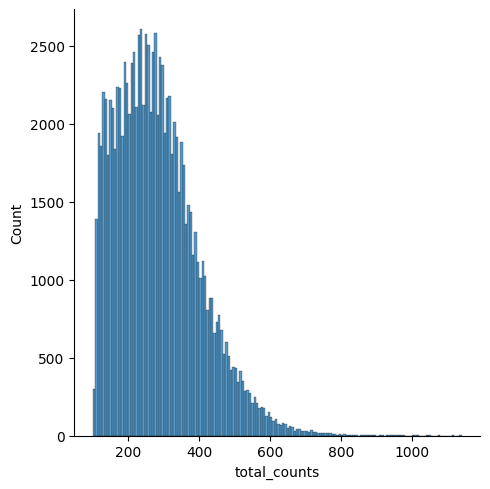

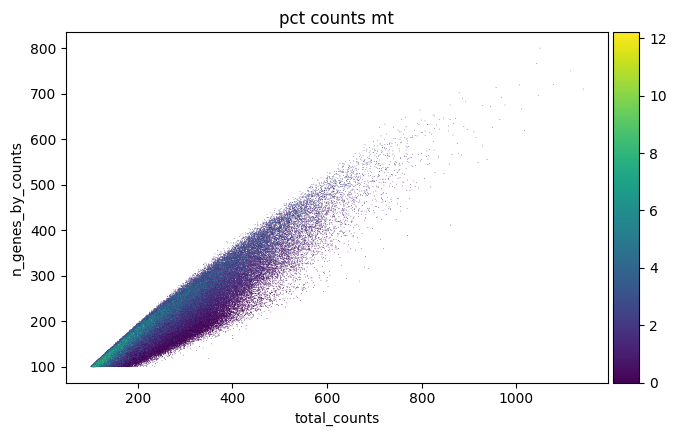

In [5]:
p1 = sc.pl.violin(bdata, "pct_counts_mt")
p2 = sns.displot(bdata.obs["total_counts"])
p3 = sc.pl.scatter(bdata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [7]:
bdata.obs["outlier"] = (
    is_outlier(bdata, "log1p_total_counts", 5)
    | is_outlier(bdata, "log1p_n_genes_by_counts", 5)
    | is_outlier(bdata, "pct_counts_in_top_20_genes", 5)
)
bdata.obs.outlier.value_counts()

outlier
False    105434
True          3
Name: count, dtype: int64

In [8]:
bdata.obs["mt_outlier"] = is_outlier(bdata, "pct_counts_mt", 3) | (
    bdata.obs["pct_counts_mt"] > 8
)
bdata.obs.mt_outlier.value_counts()

mt_outlier
False    99279
True      6158
Name: count, dtype: int64

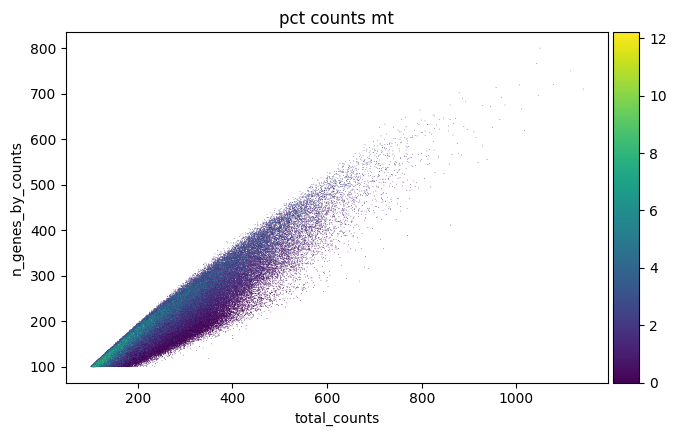

In [9]:
p1 = sc.pl.scatter(bdata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [10]:
sc.pp.highly_variable_genes(bdata,n_top_genes=5000,flavor="seurat_v3")
sc.pp.normalize_total(bdata,target_sum=1e4)
sc.pp.log1p(bdata)
predictions_8bin = celltypist.annotate(bdata, model = 'Adult_Human_Skin.pkl')
bdata = predictions_8bin.to_adata()
bdata

🔬 Input data has 105437 cells and 17074 genes
🔗 Matching reference genes in the model
🧬 2945 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


AnnData object with n_obs × n_vars = 105437 × 17074
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_labels', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

In [11]:
bdata = bdata[:, bdata.var["highly_variable"]].copy()
sc.pp.scale(bdata, max_value=10)
sc.pp.pca(bdata, use_highly_variable=True)
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)

auto.py (21): IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-08-11 14:36:17.253403: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 14:36:17.402070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754940977.455293  116150 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754940977.470024  116150 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W000

In [12]:
bdata

AnnData object with n_obs × n_vars = 105437 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier', 'predicted_labels', 'conf_score'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

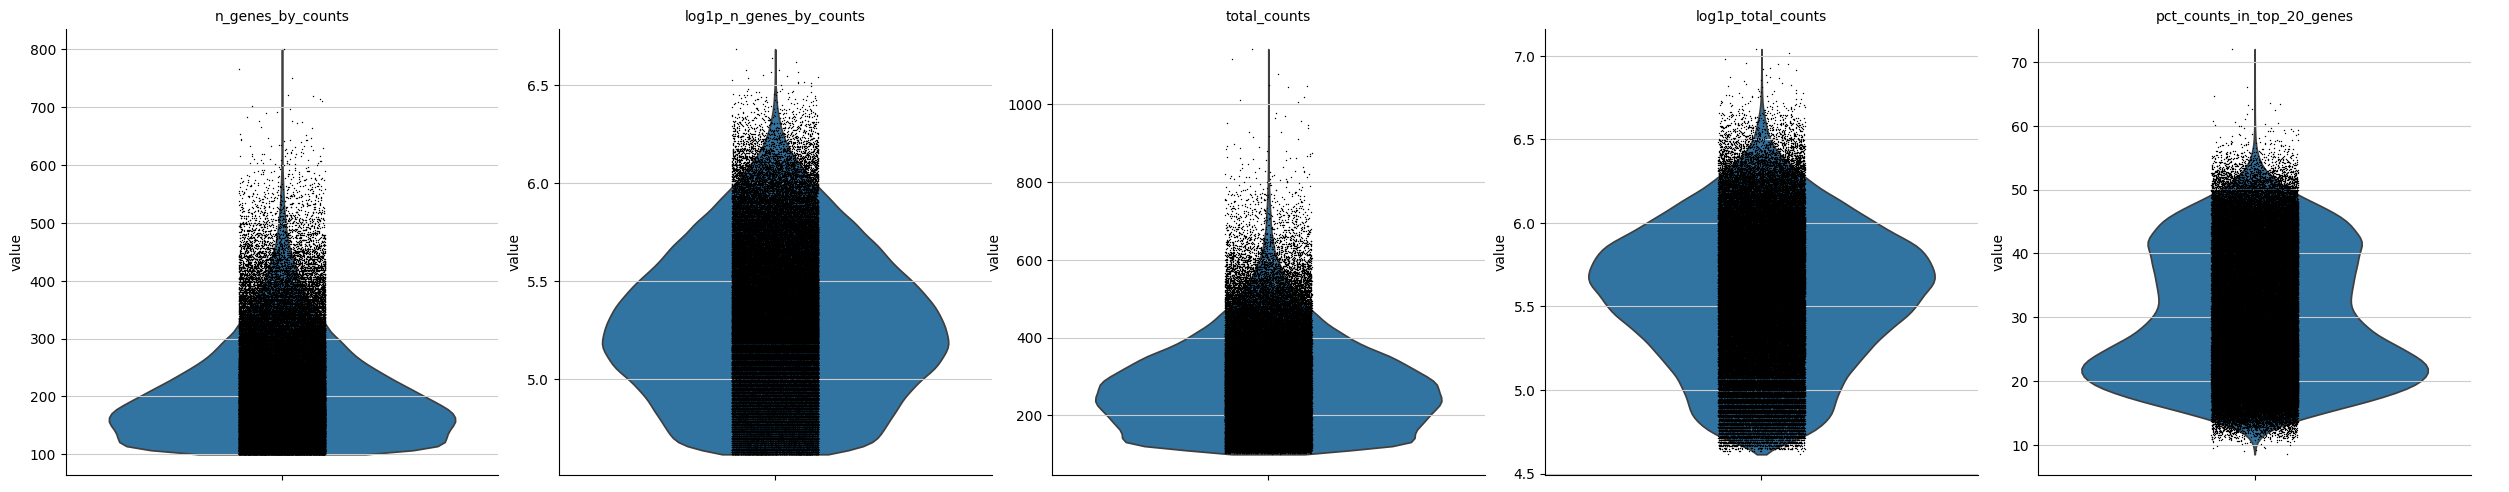

In [13]:
sc.set_figure_params(
    dpi=50,
    fontsize=10,
)
sc.pl.violin(
    bdata,
    [
        "n_genes_by_counts",
        "log1p_n_genes_by_counts",
        "total_counts",
        "log1p_total_counts",
        "pct_counts_in_top_20_genes",
    ],
    jitter=0.1,
    multi_panel=True,
)

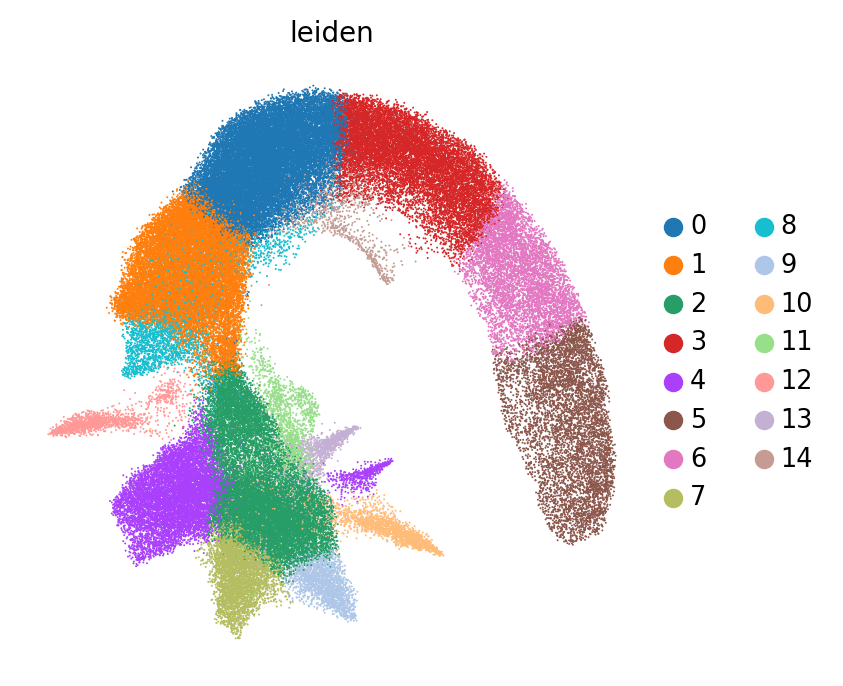

In [14]:
sc.set_figure_params(dpi=100,fontsize=10,)

sc.tl.leiden(bdata,resolution=1,key_added='leiden')
sc.pl.umap(bdata,color=['leiden'],size=2,wspace=0.25,frameon=False)

In [ ]:
b2c.scaled_he_image(bdata, mpp=0.5, save_path="stardist/he.tiff")

Cropped spatial coordinates key: spatial_cropped_150_buffer
Image key: 0.5_mpp_150_buffer


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


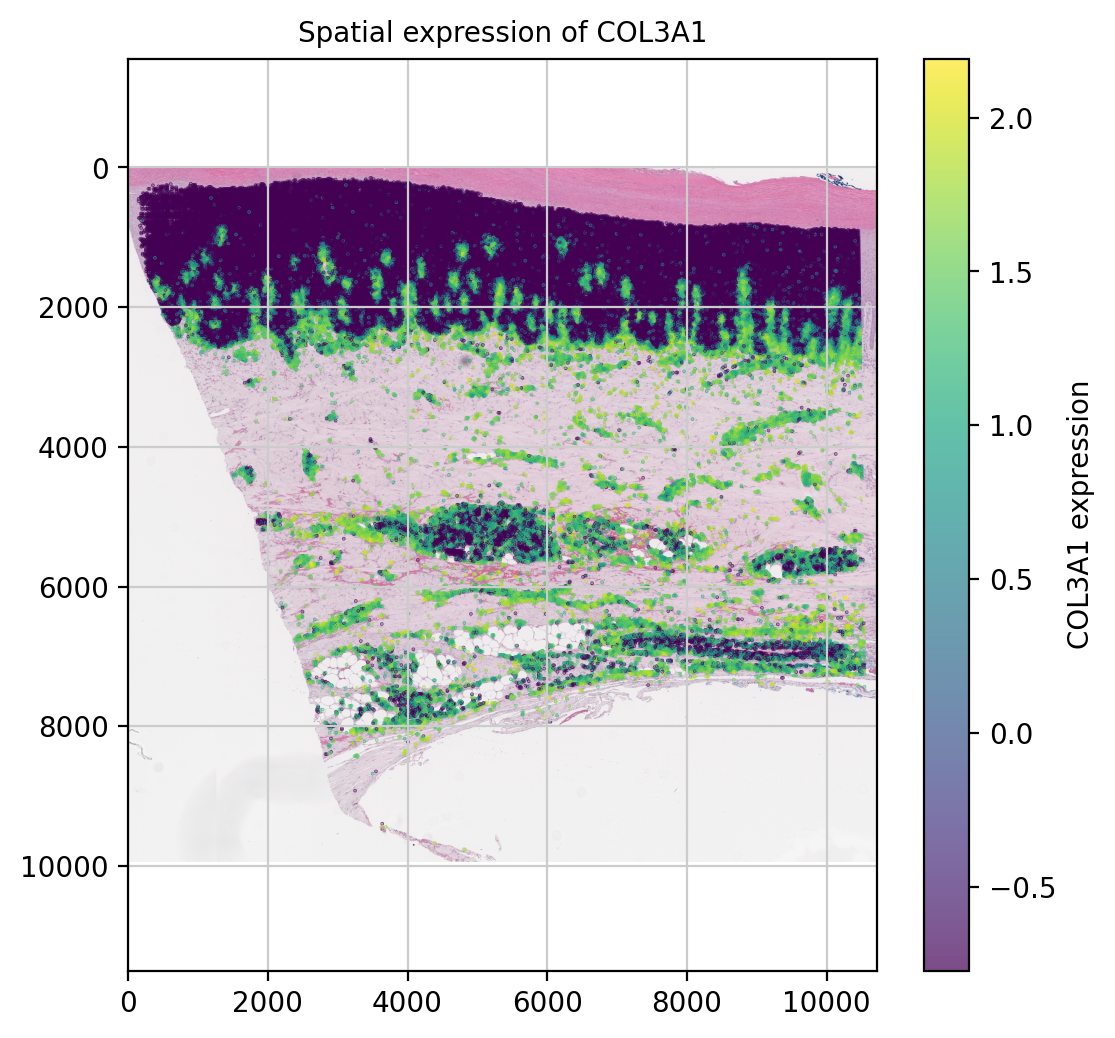

In [16]:
# spatial expression of COL3A1

gene = "COL3A1"

bg_img = Image.open("./stardist/he.tiff")
bg_width, bg_height = bg_img.size

coords = bdata.obsm["spatial_cropped_150_buffer"]
expr = bdata[:, gene].X.toarray().flatten()

plt.figure(figsize=(6, 6))
plt.imshow(bg_img, extent=[0, bg_width, bg_height, 0])
plt.scatter(coords[:, 0], coords[:, 1], c=expr, cmap="viridis", s=0.1, alpha=0.7)
plt.colorbar(label=f"{gene} expression")
plt.title(f"Spatial expression of {gene}")
plt.axis("equal")
plt.xlim(0, bg_width)
plt.ylim(bg_height, 0) 
plt.show()


In [17]:
bdata.raw.to_adata().write('skin_TXK6Z4X_A1_8um_b2c_qc.h5ad')

... storing 'feature_types' as categorical
... storing 'genome' as categorical
